# Individual glacier data inspection

This notebook will walk through steps to read in and organize velocity data and clip it to the extent of a single glacier. The tools we will use include **xarray**, **rioxarray**, **geopandas**, and **flox**. 

To clip its_live data to the extent of a single glacier we will use a vector dataset of glacier outlines, the [Randolph Glacier Inventory](https://nsidc.org/data/nsidc-0770). 

*Learning goals:*

- subset large raster to spatial area of interest
- exploring dataset with **dask** and **xarray**
- dataset inspection using
    - xarray label and index-based selections
    - grouped computations and reductions
    - visualization

First, lets install the python libraries that we'll need for this notebook:

In [1]:
import geopandas as gpd
import os
import numpy as np
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from shapely.geometry import Point
import cartopy
import json
import urllib.request
import pandas as pd

%config InlineBackend.figure_format='retina'

In [2]:
from dask.distributed import Client, LocalCluster
import psutil
import logging

In [3]:
#cluster = LocalCluster(
#    n_workers = psutil.cpu_count(logical=True)-1, 
#    silence_logs = logging.ERROR, 
#    threads_per_worker=1,
#)
#client = Client(cluster)
#client

## Reading in ITS_LIVE data --Initial

We will use some of the functions we defined in the data access notebook in this notebook and others within this tutorial. They are all stored in the `itslivetools.py` file. If you cloned this tutorial from its github [repository](https://github.com/e-marshall/itslive) you'll see that `itslivetools.py` is in the same directory as our current notebook, so we can import it with the following line: 

In [3]:
import itslivetools

First, let's read in the catalog again:  

In [4]:
itslive_catalog = gpd.read_file('https://its-live-data.s3.amazonaws.com/datacubes/catalog_v02.json')

Next, we'll use the `gind_granule_by_point()` and `read_in_s3()` functions to read in the ITS_LIVE zarr datacube as an xarray.Dataset object. 

The `read_in_s3()` function will take a url that points to a zarr data cube stored in an AWS S3 bucket and return an xarray dataset. 

I started with `chunk_size='auto'` which will choose chunk sizes that match the underlying data structure (this is generally ideal). More about choosing good chunk sizes [here](https://blog.dask.org/2021/11/02/choosing-dask-chunk-sizes). If you want to use a different chunk size, specify it when you call the `read_in_s3()` function.

In [5]:
url = itslivetools.find_granule_by_point([95.180191, 30.645973])
url

'http://its-live-data.s3.amazonaws.com/datacubes/v2/N30E090/ITS_LIVE_vel_EPSG32646_G0120_X750000_Y3350000.zarr'

In [6]:
dc = itslivetools.read_in_s3(url)
dc

<xarray.Dataset>
Dimensions:                     (mid_date: 25243, y: 833, x: 833)
Coordinates:
  * mid_date                    (mid_date) datetime64[ns] 2022-06-07T04:21:44...
  * x                           (x) float64 7.001e+05 7.003e+05 ... 8e+05
  * y                           (y) float64 3.4e+06 3.4e+06 ... 3.3e+06 3.3e+06
Data variables: (12/60)
    M11                         (mid_date, y, x) float32 dask.array<chunksize=(25243, 30, 30), meta=np.ndarray>
    M11_dr_to_vr_factor         (mid_date) float32 dask.array<chunksize=(25243,), meta=np.ndarray>
    M12                         (mid_date, y, x) float32 dask.array<chunksize=(25243, 30, 30), meta=np.ndarray>
    M12_dr_to_vr_factor         (mid_date) float32 dask.array<chunksize=(25243,), meta=np.ndarray>
    acquisition_date_img1       (mid_date) datetime64[ns] dask.array<chunksize=(25243,), meta=np.ndarray>
    acquisition_date_img2       (mid_date) datetime64[ns] dask.array<chunksize=(25243,), meta=np.ndarray>
    ...                          ...
    vy_error_modeled            (mid_date) float32 dask.array<chunksize=(25243,), meta=np.ndarray>
    vy_error_slow               (mid_date) float32 dask.array<chunksize=(25243,), meta=np.ndarray>
    vy_error_stationary         (mid_date) float32 dask.array<chunksize=(25243,), meta=np.ndarray>
    vy_stable_shift             (mid_date) float32 dask.array<chunksize=(25243,), meta=np.ndarray>
    vy_stable_shift_slow        (mid_date) float32 dask.array<chunksize=(25243,), meta=np.ndarray>
    vy_stable_shift_stationary  (mid_date) float32 dask.array<chunksize=(25243,), meta=np.ndarray>
Attributes: (12/19)
    Conventions:                CF-1.8
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               25-Sep-2023 22:00:23
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v2/N30E090/ITS_L...
    skipped_granules:           s3://its-live-data/datacubes/v2/N30E090/ITS_L...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

We are reading this in as a dask array. Let's take a look at the chunk sizes:

```{note} 
chunksizes shows the largest chunk size. chunks shows the sizes of all chunks along all dims, better if you have irregular chunks
```

In [8]:
dc.chunksizes

ValueError: Object has inconsistent chunks along dimension y. This can be fixed by calling unify_chunks().

As suggested in the error message, apply the `unify_chunks()` method: 

In [7]:
dc = dc.unify_chunks()

Great, that worked. Now we can see the chunk sizes of the dataset:

In [8]:
dc.chunksizes

Frozen({'mid_date': (25243,), 'y': (30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 23), 'x': (30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 23)})

```{note} 
Setting the dask chunksize to `auto` at the `xr.open_dataset()` step will use chunk sizes that most closely resemble the structure of the underlying data. To avoid imposing a chunk size that isn't a good fit for the data, avoid re-chunking until we have selected a subset of our area of interest from the larger dataset 
```

Check CRS of xr object: 

In [11]:
dc.attrs['projection']

'32646'

Let's take a look at the time dimension (`mid_date` here). To start with we'll just print the first 10 values:

In [12]:
for element in range(10):
    
    print(dc.mid_date[element].data)

2022-06-07T04:21:44.211208960
2018-04-14T04:18:49.171219968
2017-02-10T16:15:50.660901120
2022-04-03T04:19:01.211214080
2021-07-22T04:16:46.210427904
2019-03-15T04:15:44.180925952
2002-09-15T03:59:12.379172096
2002-12-28T03:42:16.181281024
2021-06-29T16:16:10.210323968
2022-03-26T16:18:35.211123968


It doesn't look like the time dimension is in chronological order, let's fix that: 

```{note}
The following cell is commented out because it produces an error and usually leads to a dead kernel. Let's try to troubleshoot this below. 
{add image of error (in screenshots)}

In [9]:
dc_timesorted = dc.sortby(dc['mid_date'])


### Note: work-around for situation where above cell produces error

```{note}
In some test cases, the above cell triggered the following error. While the current version runs fine, I'm including a work around in the following cells in case you encounter this error as well. If you don't, feel free to skip ahead to the next sub-section heading{add image of error (in screenshots)}
```

Let's follow some [internet advice](https://twitter.com/jeremy_mcgibbon/status/1496219098849718274) and try to fix this issue. We will actually start over from the very beginning and read in the dataset using only `xarray` and not `dask`. 

In [17]:
dc_new = xr.open_dataset(url, engine='zarr')

Now we have an `xr.Dataset` that is built on `numpy` arrays rather than `dask` arrays, which means we can re-index along the time dimension using xarray's 'lazy' functionality:

In [18]:
dc_new_timesorted = dc_new.sortby(dc_new['mid_date'])

In [19]:
for element in range(10):
    
    print(dc_new_timesorted.mid_date[element].data)

1986-09-11T03:31:15.003252992
1986-10-05T03:31:06.144750016
1986-10-21T03:31:34.493249984
1986-11-22T03:29:27.023556992
1986-11-30T03:29:08.710132992
1986-12-08T03:29:55.372057024
1986-12-08T03:33:17.095283968
1986-12-16T03:30:10.645544000
1986-12-24T03:29:52.332120960
1987-01-09T03:30:01.787228992


Great, much easier. Now, we will chunk the dataset.

In [22]:
dc_new_timesorted = dc_new_timesorted.chunk()

In [23]:
dc_new_timesorted.chunks

Frozen({'mid_date': (25243,), 'y': (833,), 'x': (833,)})

In [24]:
dc_new_timesorted

<xarray.Dataset>
Dimensions:                     (mid_date: 25243, y: 833, x: 833)
Coordinates:
  * mid_date                    (mid_date) datetime64[ns] 1986-09-11T03:31:15...
  * x                           (x) float64 7.001e+05 7.003e+05 ... 8e+05
  * y                           (y) float64 3.4e+06 3.4e+06 ... 3.3e+06 3.3e+06
Data variables: (12/60)
    M11                         (mid_date, y, x) float32 dask.array<chunksize=(25243, 833, 833), meta=np.ndarray>
    M11_dr_to_vr_factor         (mid_date) float32 dask.array<chunksize=(25243,), meta=np.ndarray>
    M12                         (mid_date, y, x) float32 dask.array<chunksize=(25243, 833, 833), meta=np.ndarray>
    M12_dr_to_vr_factor         (mid_date) float32 dask.array<chunksize=(25243,), meta=np.ndarray>
    acquisition_date_img1       (mid_date) datetime64[ns] dask.array<chunksize=(25243,), meta=np.ndarray>
    acquisition_date_img2       (mid_date) datetime64[ns] dask.array<chunksize=(25243,), meta=np.ndarray>
    ...                          ...
    vy_error_modeled            (mid_date) float32 dask.array<chunksize=(25243,), meta=np.ndarray>
    vy_error_slow               (mid_date) float32 dask.array<chunksize=(25243,), meta=np.ndarray>
    vy_error_stationary         (mid_date) float32 dask.array<chunksize=(25243,), meta=np.ndarray>
    vy_stable_shift             (mid_date) float32 dask.array<chunksize=(25243,), meta=np.ndarray>
    vy_stable_shift_slow        (mid_date) float32 dask.array<chunksize=(25243,), meta=np.ndarray>
    vy_stable_shift_stationary  (mid_date) float32 dask.array<chunksize=(25243,), meta=np.ndarray>
Attributes: (12/19)
    Conventions:                CF-1.8
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               25-Sep-2023 22:00:23
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v2/N30E090/ITS_L...
    skipped_granules:           s3://its-live-data/datacubes/v2/N30E090/ITS_L...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

You can see in the above object that while we techincally now have a 'chunked dataset', the entire object is 

In [102]:
chunking_dict = dc.chunksizes
chunking_dict

Frozen({'mid_date': (32752, 7248, 14464), 'y': (20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 13), 'x': (20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 13)})

In [103]:
dc_rechunk = dc_new.chunk(chunking_dict)

In [104]:
dc_rechunk.chunks

Frozen({'mid_date': (32752, 7248, 14464), 'y': (20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 13), 'x': (20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 13)})

Great, now we have our ITS_LIVE dataset, organized by time and with appropriate chunking. Let's move on and read in vector data describing some physical features we'd like to examine with the ITS_LIVE dataset.

## Read in vector data 

We are going to read in RGI region 15 (SouthAsiaEast). RGI data is downloaded in lat/lon coordinates. We will project it to match the CRS of the ITS_LIVE dataset and then select an individual glacier to begin our analysis.

In [10]:
#se_asia = gpd.read_file('https://github.com/e-marshall/itslive/raw/master/rgi15_southasiaeast.geojson')
se_asia = gpd.read_parquet('rgi7_region15_south_asia_east.parquet')

In [11]:
dc.attrs['projection']

'32646'

In [12]:
#project rgi data to match itslive
#we know the epsg from looking at the 'spatial epsg' attr of the mapping var of the dc object
se_asia_prj = se_asia.to_crs(f'EPSG:{dc.attrs["projection"]}') 
se_asia_prj.head(3)

rgi_id o1region o2region        glims_id  anlys_id   
0  RGI2000-v7.0-G-15-00001       15    15-01  G078088E31398N    866850  \
1  RGI2000-v7.0-G-15-00002       15    15-01  G078125E31399N    867227   
2  RGI2000-v7.0-G-15-00003       15    15-01  G078128E31390N    867273   

   subm_id             src_date     cenlon     cenlat  utm_zone  ...   
0      752  2002-07-10T00:00:00  78.087891  31.398046        44  ...  \
1      752  2002-07-10T00:00:00  78.123699  31.397796        44  ...   
2      752  2000-08-05T00:00:00  78.128510  31.390287        44  ...   

      zmin_m     zmax_m     zmed_m    zmean_m  slope_deg  aspect_deg   
0  4662.2950  4699.2095  4669.4720  4671.4253  13.427070  122.267290  \
1  4453.3584  4705.9920  4570.9473  4571.2770  22.822983  269.669144   
2  4791.7593  4858.6807  4832.1836  4827.6700  15.626262  212.719681   

   aspect_sec  dem_source  lmax_m   
0           4    COPDEM30     173  \
1           7    COPDEM30    1113   
2           6    COPDEM30     327   

                                            geometry  
0  POLYGON Z ((-924868.476 3571663.111 0.000, -92...  
1  POLYGON Z ((-921270.161 3571706.471 0.000, -92...  
2  POLYGON Z ((-921061.745 3570342.665 0.000, -92...  

[3 rows x 29 columns]

## Crop RGI to ITS_LIVE extent


In [13]:
#first, get vector bbox of itslive
bbox_dc = itslivetools.get_bounds_polygon(dc)
bbox_dc['geometry']

0    POLYGON ((700132.500 3300067.500, 799972.500 3...
Name: geometry, dtype: geometry

In [14]:
#project from latlon to local utm 
bbox_dc = bbox_dc.to_crs(f'EPSG:{dc.attrs["projection"]}')
bbox_dc

geometry
0  POLYGON ((700132.500 3300067.500, 799972.500 3...

<Axes: >

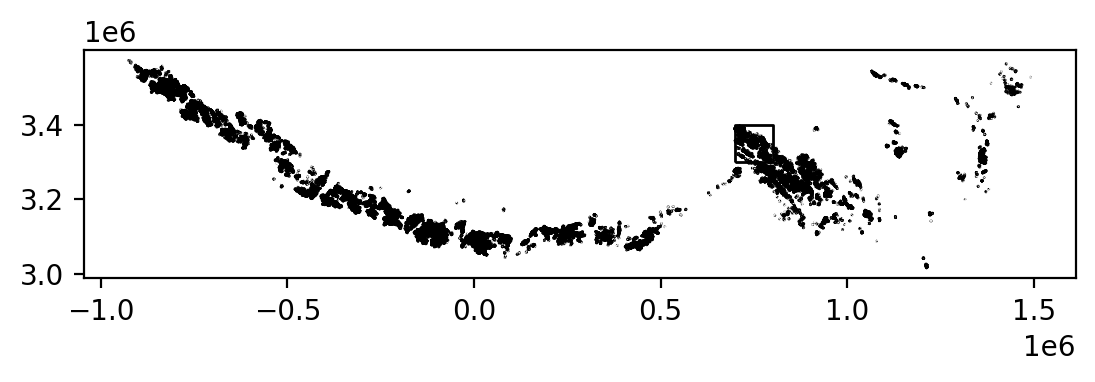

In [150]:
#plot the outline of the itslive granule and the rgi dataframe together
fig, ax = plt.subplots()

bbox_dc.plot(ax=ax, facecolor='None')
se_asia_prj.plot(ax=ax, facecolor='None')

In [15]:
#subset rgi to bounds 
se_asia_subset = gpd.clip(se_asia_prj, bbox_dc)
se_asia_subset.head()

rgi_id o1region o2region        glims_id  anlys_id   
16373  RGI2000-v7.0-G-15-16374       15    15-03  G095930E29817N    930178  \
16374  RGI2000-v7.0-G-15-16375       15    15-03  G095925E29818N    930160   
16376  RGI2000-v7.0-G-15-16377       15    15-03  G095915E29820N    930107   
16371  RGI2000-v7.0-G-15-16372       15    15-03  G095936E29819N    930215   
15879  RGI2000-v7.0-G-15-15880       15    15-03  G095459E29807N    928789   

       subm_id             src_date     cenlon     cenlat  utm_zone  ...   
16373      752  2005-09-08T00:00:00  95.929916  29.817003        46  ...  \
16374      752  2005-09-08T00:00:00  95.925181  29.818399        46  ...   
16376      752  2005-09-08T00:00:00  95.914583  29.819510        46  ...   
16371      752  2005-09-08T00:00:00  95.935554  29.819123        46  ...   
15879      752  1999-07-29T00:00:00  95.459374  29.807181        46  ...   

          zmin_m     zmax_m     zmed_m    zmean_m  slope_deg  aspect_deg   
16373  4985.7314  5274.0435  5142.7660  5148.8170  27.024134  139.048110  \
16374  4856.2790  5054.9253  4929.5560  4933.6890  44.126980  211.518448   
16376  5072.8910  5150.6196  5108.5020  5111.7217  23.980000  219.341537   
16371  4838.7646  5194.8840  5001.5117  4992.3706  25.684517  128.737870   
15879  3802.1846  4155.1255  4000.2695  4000.4404  28.155806  116.148640   

       aspect_sec  dem_source  lmax_m   
16373           4    COPDEM30     756  \
16374           6    COPDEM30     366   
16376           6    COPDEM30     170   
16371           4    COPDEM30     931   
15879           4    COPDEM30     776   

                                                geometry  
16373  POLYGON Z ((783110.719 3302487.481 0.000, 7831...  
16374  POLYGON Z ((782511.360 3302381.154 0.000, 7825...  
16376  POLYGON Z ((781619.822 3302305.074 0.000, 7816...  
16371  POLYGON Z ((783420.055 3302493.804 0.000, 7834...  
15879  POLYGON Z ((737667.211 3300277.169 0.000, 7377...  

[5 rows x 29 columns]

We can use the `geopandas` `.explore()` method to take a look at the RGI dataset:

In [152]:
se_asia_subset.explore()

/home/emmamarshall/miniconda3/envs/itslive_tutorial/lib/python3.11/site-packages/folium/features.py:1102: UserWarning: GeoJsonTooltip is not configured to render for GeoJson GeometryCollection geometries. Please consider reworking these features: [{'rgi_id': 'RGI2000-v7.0-G-15-16433', 'o1region': '15', 'o2region': '15-03', 'glims_id': 'G095721E29941N', 'anlys_id': 929520, 'subm_id': 752, 'src_date': '2005-09-08T00:00:00', 'cenlon': 95.7211016152286, 'cenlat': 29.940902187781784, 'utm_zone': 46, 'area_km2': 0.340954350813452, 'primeclass': 0, 'conn_lvl': 0, 'surge_type': 0, 'term_type': 9, 'glac_name': None, 'is_rgi6': 0, 'termlon': 95.72222864596793, 'termlat': 29.937137080413784, 'zmin_m': 4657.792, 'zmax_m': 5049.5625, 'zmed_m': 4825.1104, 'zmean_m': 4839.4185, 'slope_deg': 23.704372, 'aspect_deg': 145.20973, 'aspect_sec': 4, 'dem_source': 'COPDEM30', 'lmax_m': 891}, {'rgi_id': 'RGI2000-v7.0-G-15-12194', 'o1region': '15', 'o2region': '15-03', 'glims_id': 'G095869E30315N', 'anlys_id':

We'll choose a single glacier to work with for now:

In [16]:
sample_glacier_vec = se_asia_subset.loc[se_asia_subset['rgi_id'] == 'RGI2000-v7.0-G-15-11754']
sample_glacier_vec

rgi_id o1region o2region        glims_id  anlys_id   
11753  RGI2000-v7.0-G-15-11754       15    15-03  G095137E30633N    927615  \

       subm_id             src_date    cenlon     cenlat  utm_zone  ...   
11753      752  2002-07-10T00:00:00  95.13716  30.633165        46  ...  \

          zmin_m    zmax_m     zmed_m    zmean_m  slope_deg aspect_deg   
11753  4275.9062  5981.547  5257.6377  5155.8335  16.769985   68.71781  \

       aspect_sec  dem_source  lmax_m   
11753           3    COPDEM90   11563  \

                                                geometry  
11753  POLYGON Z ((700799.699 3387922.813 0.000, 7007...  

[1 rows x 29 columns]

### Clip ITS_LIVE dataset to individual glacier extent

First, we need to use `rio.write_crs()` to assign a CRS to the itslive object. If we don't do that first the `rio.clip()` command will produce an error


*Note*: you can only run write_crs() once, because it switches mapping from being a `data_var` to a `coord` so if you run it again it will produce a key error looking for a var that doesnt' exist

In [17]:
dc = dc.rio.write_crs(f"epsg:{dc.attrs['projection']}", inplace=True)

In [20]:
%%time

sample_glacier_raster = dc.rio.clip(sample_glacier_vec.geometry, sample_glacier_vec.crs)

CPU times: user 472 ms, sys: 7.48 ms, total: 479 ms
Wall time: 488 ms


In [29]:
sample_glacier_raster

<xarray.Dataset>
Dimensions:                     (mid_date: 25243, x: 73, y: 64)
Coordinates:
  * mid_date                    (mid_date) datetime64[ns] 2022-06-07T04:21:44...
  * x                           (x) float64 7.003e+05 7.004e+05 ... 7.089e+05
  * y                           (y) float64 3.395e+06 3.395e+06 ... 3.387e+06
    mapping                     int64 0
Data variables: (12/59)
    M11                         (mid_date, y, x) float32 dask.array<chunksize=(25243, 16, 29), meta=np.ndarray>
    M11_dr_to_vr_factor         (mid_date) float32 dask.array<chunksize=(25243,), meta=np.ndarray>
    M12                         (mid_date, y, x) float32 dask.array<chunksize=(25243, 16, 29), meta=np.ndarray>
    M12_dr_to_vr_factor         (mid_date) float32 dask.array<chunksize=(25243,), meta=np.ndarray>
    acquisition_date_img1       (mid_date) datetime64[ns] dask.array<chunksize=(25243,), meta=np.ndarray>
    acquisition_date_img2       (mid_date) datetime64[ns] dask.array<chunksize=(25243,), meta=np.ndarray>
    ...                          ...
    vy_error_modeled            (mid_date) float32 dask.array<chunksize=(25243,), meta=np.ndarray>
    vy_error_slow               (mid_date) float32 dask.array<chunksize=(25243,), meta=np.ndarray>
    vy_error_stationary         (mid_date) float32 dask.array<chunksize=(25243,), meta=np.ndarray>
    vy_stable_shift             (mid_date) float32 dask.array<chunksize=(25243,), meta=np.ndarray>
    vy_stable_shift_slow        (mid_date) float32 dask.array<chunksize=(25243,), meta=np.ndarray>
    vy_stable_shift_stationary  (mid_date) float32 dask.array<chunksize=(25243,), meta=np.ndarray>
Attributes: (12/19)
    Conventions:                CF-1.8
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               25-Sep-2023 22:00:23
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v2/N30E090/ITS_L...
    skipped_granules:           s3://its-live-data/datacubes/v2/N30E090/ITS_L...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

Take a look at the clipped object:

In [28]:
sample_glacier_raster.mid_date

<xarray.DataArray 'mid_date' (mid_date: 25243)>
array(['2022-06-07T04:21:44.211208960', '2018-04-14T04:18:49.171219968',
       '2017-02-10T16:15:50.660901120', ..., '2013-05-20T04:08:31.155972096',
       '2015-10-17T04:11:05.527512064', '2015-11-10T04:11:15.457366016'],
      dtype='datetime64[ns]')
Coordinates:
  * mid_date  (mid_date) datetime64[ns] 2022-06-07T04:21:44.211208960 ... 201...
    mapping   int64 0
Attributes:
    description:    midpoint of image 1 and image 2 acquisition date and time...
    standard_name:  image_pair_center_date_with_time_separation

In [33]:
sample_glacier_raster = sample_glacier_raster.where(sample_glacier_raster.mid_date.dt.year > 2016, drop=True)


In [35]:
sample_glacier_raster = sample_glacier_raster.where(sample_glacier_raster.mid_date.dt.year < 2020, drop=True)

What satellite sensors are represented in this time series subset?

In [40]:
set(sample_glacier_raster.satellite_img1.values)

{'1A', '2A', '2B', '7', '8'}

In [41]:
sample_glacier_raster = sample_glacier_raster.compute()

In [42]:
sample_glacier_raster

<xarray.Dataset>
Dimensions:                     (mid_date: 3974, y: 64, x: 73)
Coordinates:
  * mid_date                    (mid_date) datetime64[ns] 2018-04-14T04:18:49...
  * x                           (x) float64 7.003e+05 7.004e+05 ... 7.089e+05
  * y                           (y) float64 3.395e+06 3.395e+06 ... 3.387e+06
    mapping                     int64 0
Data variables: (12/59)
    M11                         (mid_date, y, x) float32 nan nan nan ... nan nan
    M11_dr_to_vr_factor         (mid_date) float32 nan nan nan ... nan nan nan
    M12                         (mid_date, y, x) float32 nan nan nan ... nan nan
    M12_dr_to_vr_factor         (mid_date) float32 nan nan nan ... nan nan nan
    acquisition_date_img1       (mid_date) datetime64[ns] 2017-12-20T04:21:49...
    acquisition_date_img2       (mid_date) datetime64[ns] 2018-08-07T04:15:49...
    ...                          ...
    vy_error_modeled            (mid_date) float32 40.5 28.6 27.4 ... 97.0 166.2
    vy_error_slow               (mid_date) float32 8.0 1.7 1.2 ... 9.7 11.3 25.4
    vy_error_stationary         (mid_date) float32 8.0 1.7 1.2 ... 9.7 11.3 25.4
    vy_stable_shift             (mid_date) float32 8.9 -4.9 -0.7 ... -3.6 -10.8
    vy_stable_shift_slow        (mid_date) float32 8.9 -4.9 -0.7 ... -3.6 -10.7
    vy_stable_shift_stationary  (mid_date) float32 8.9 -4.9 -0.7 ... -3.6 -10.8
Attributes: (12/19)
    Conventions:                CF-1.8
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               25-Sep-2023 22:00:23
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v2/N30E090/ITS_L...
    skipped_granules:           s3://its-live-data/datacubes/v2/N30E090/ITS_L...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

Let's take a look at the clipped raster alongside the vector outline. To start with and for the sake of easy visualizing we will take the mean of the magnitude of velocity variable along the `mid_date` dimension:

In [33]:
sample_glacier_raster_timemean = sample_glacier_raster.mean(dim='mid_date')

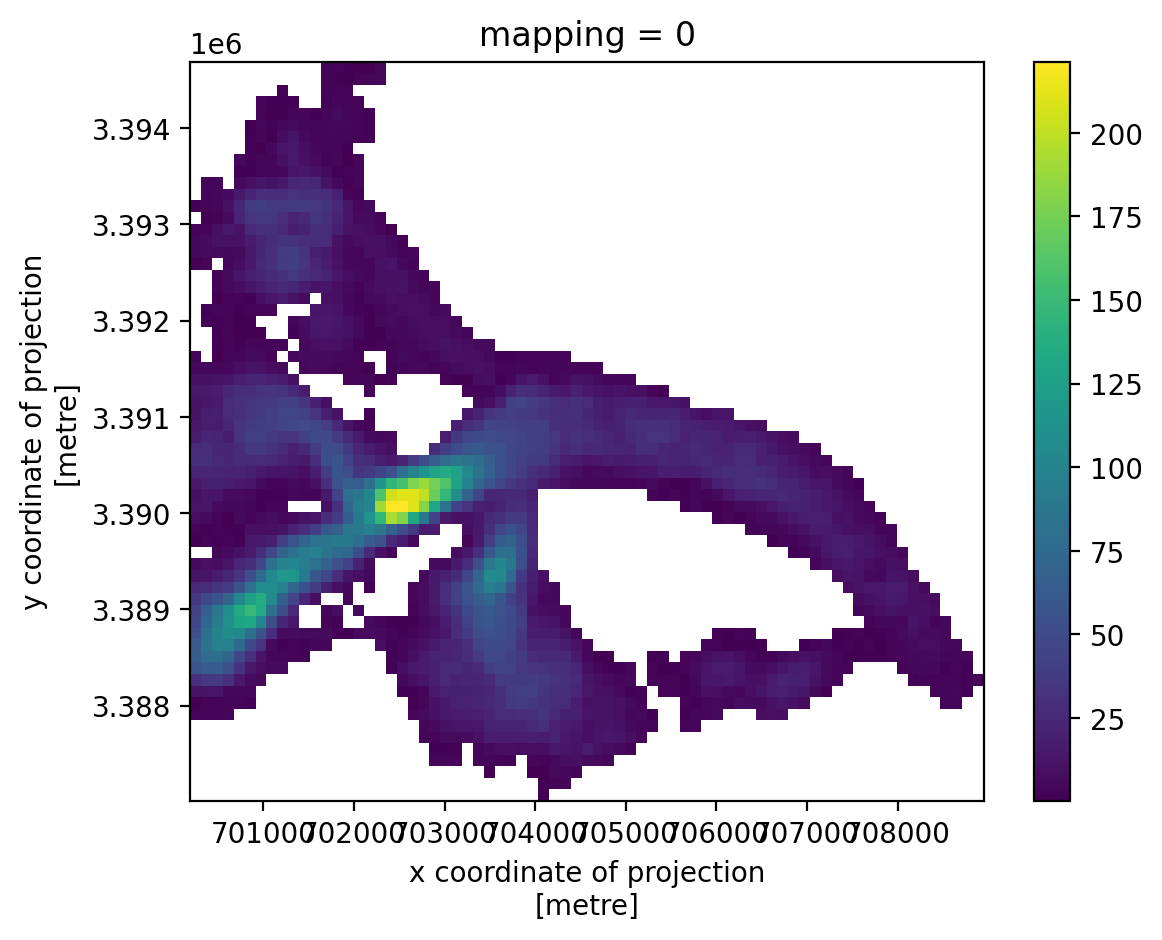

In [36]:
np.sqrt(sample_glacier_raster_timemean.vx**2 + sample_glacier_raster_timemean.vy**2).plot()

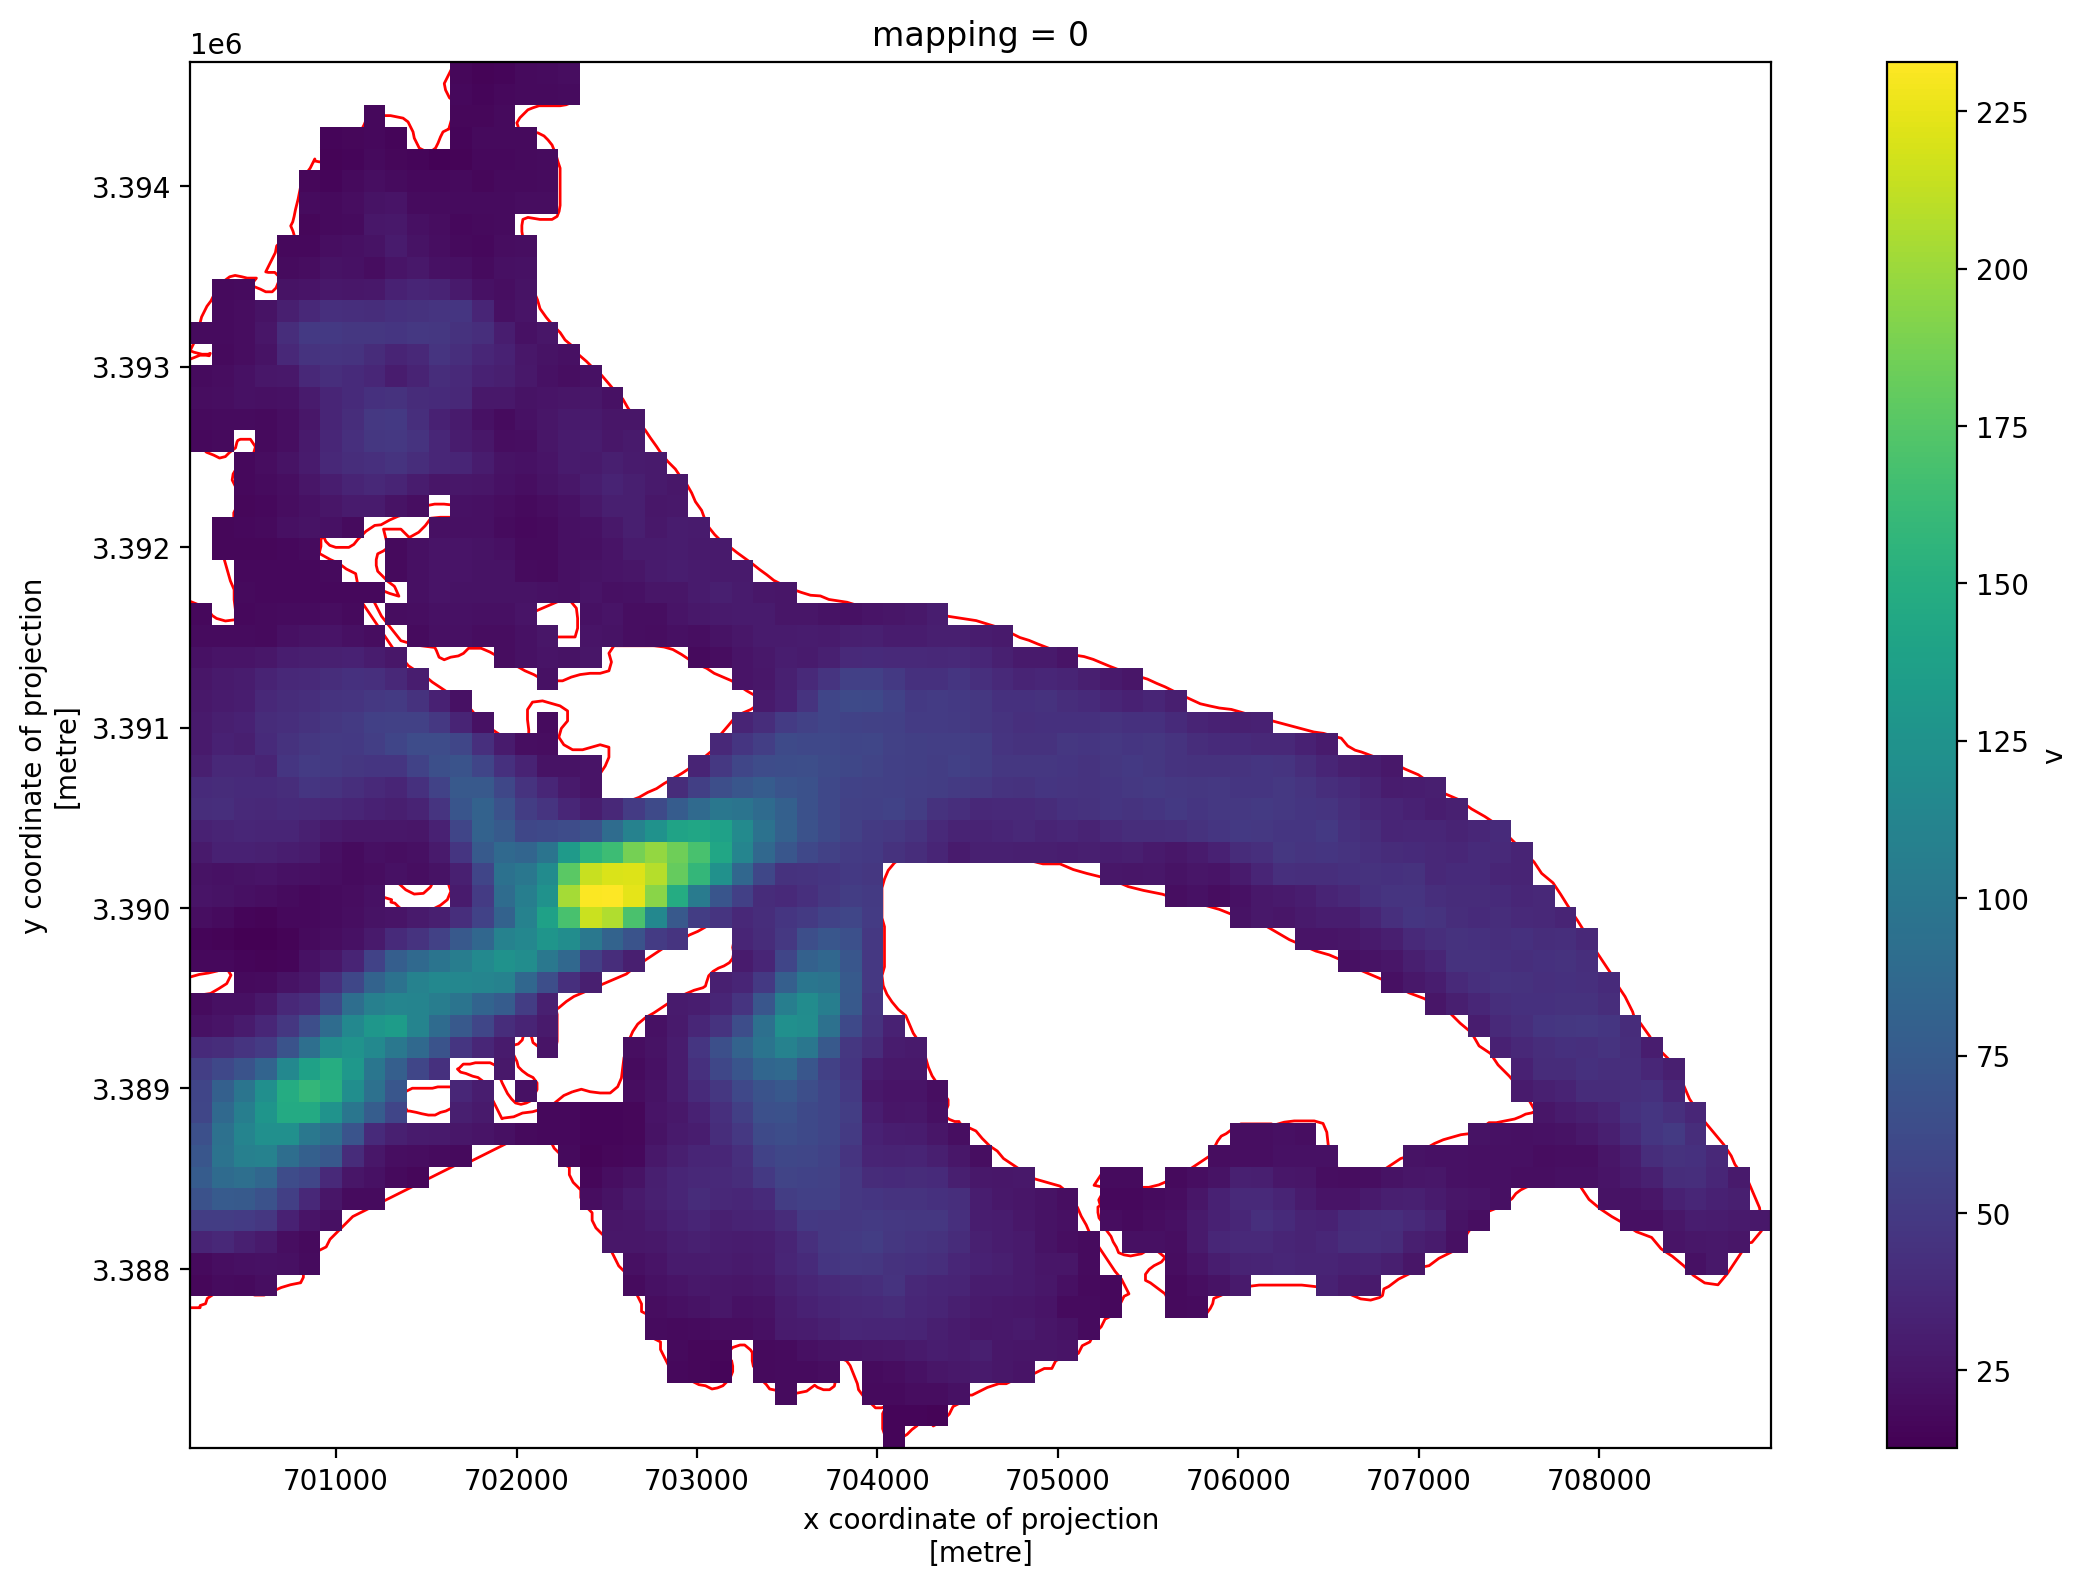

In [35]:
fig, ax = plt.subplots(figsize = (15,9))
sample_glacier_vec.plot(ax=ax, facecolor='none', edgecolor='red');
sample_glacier_raster.v.mean(dim=['mid_date']).plot(ax=ax);



Now let's take a look at the x and y components of velocity, again averaging over time:

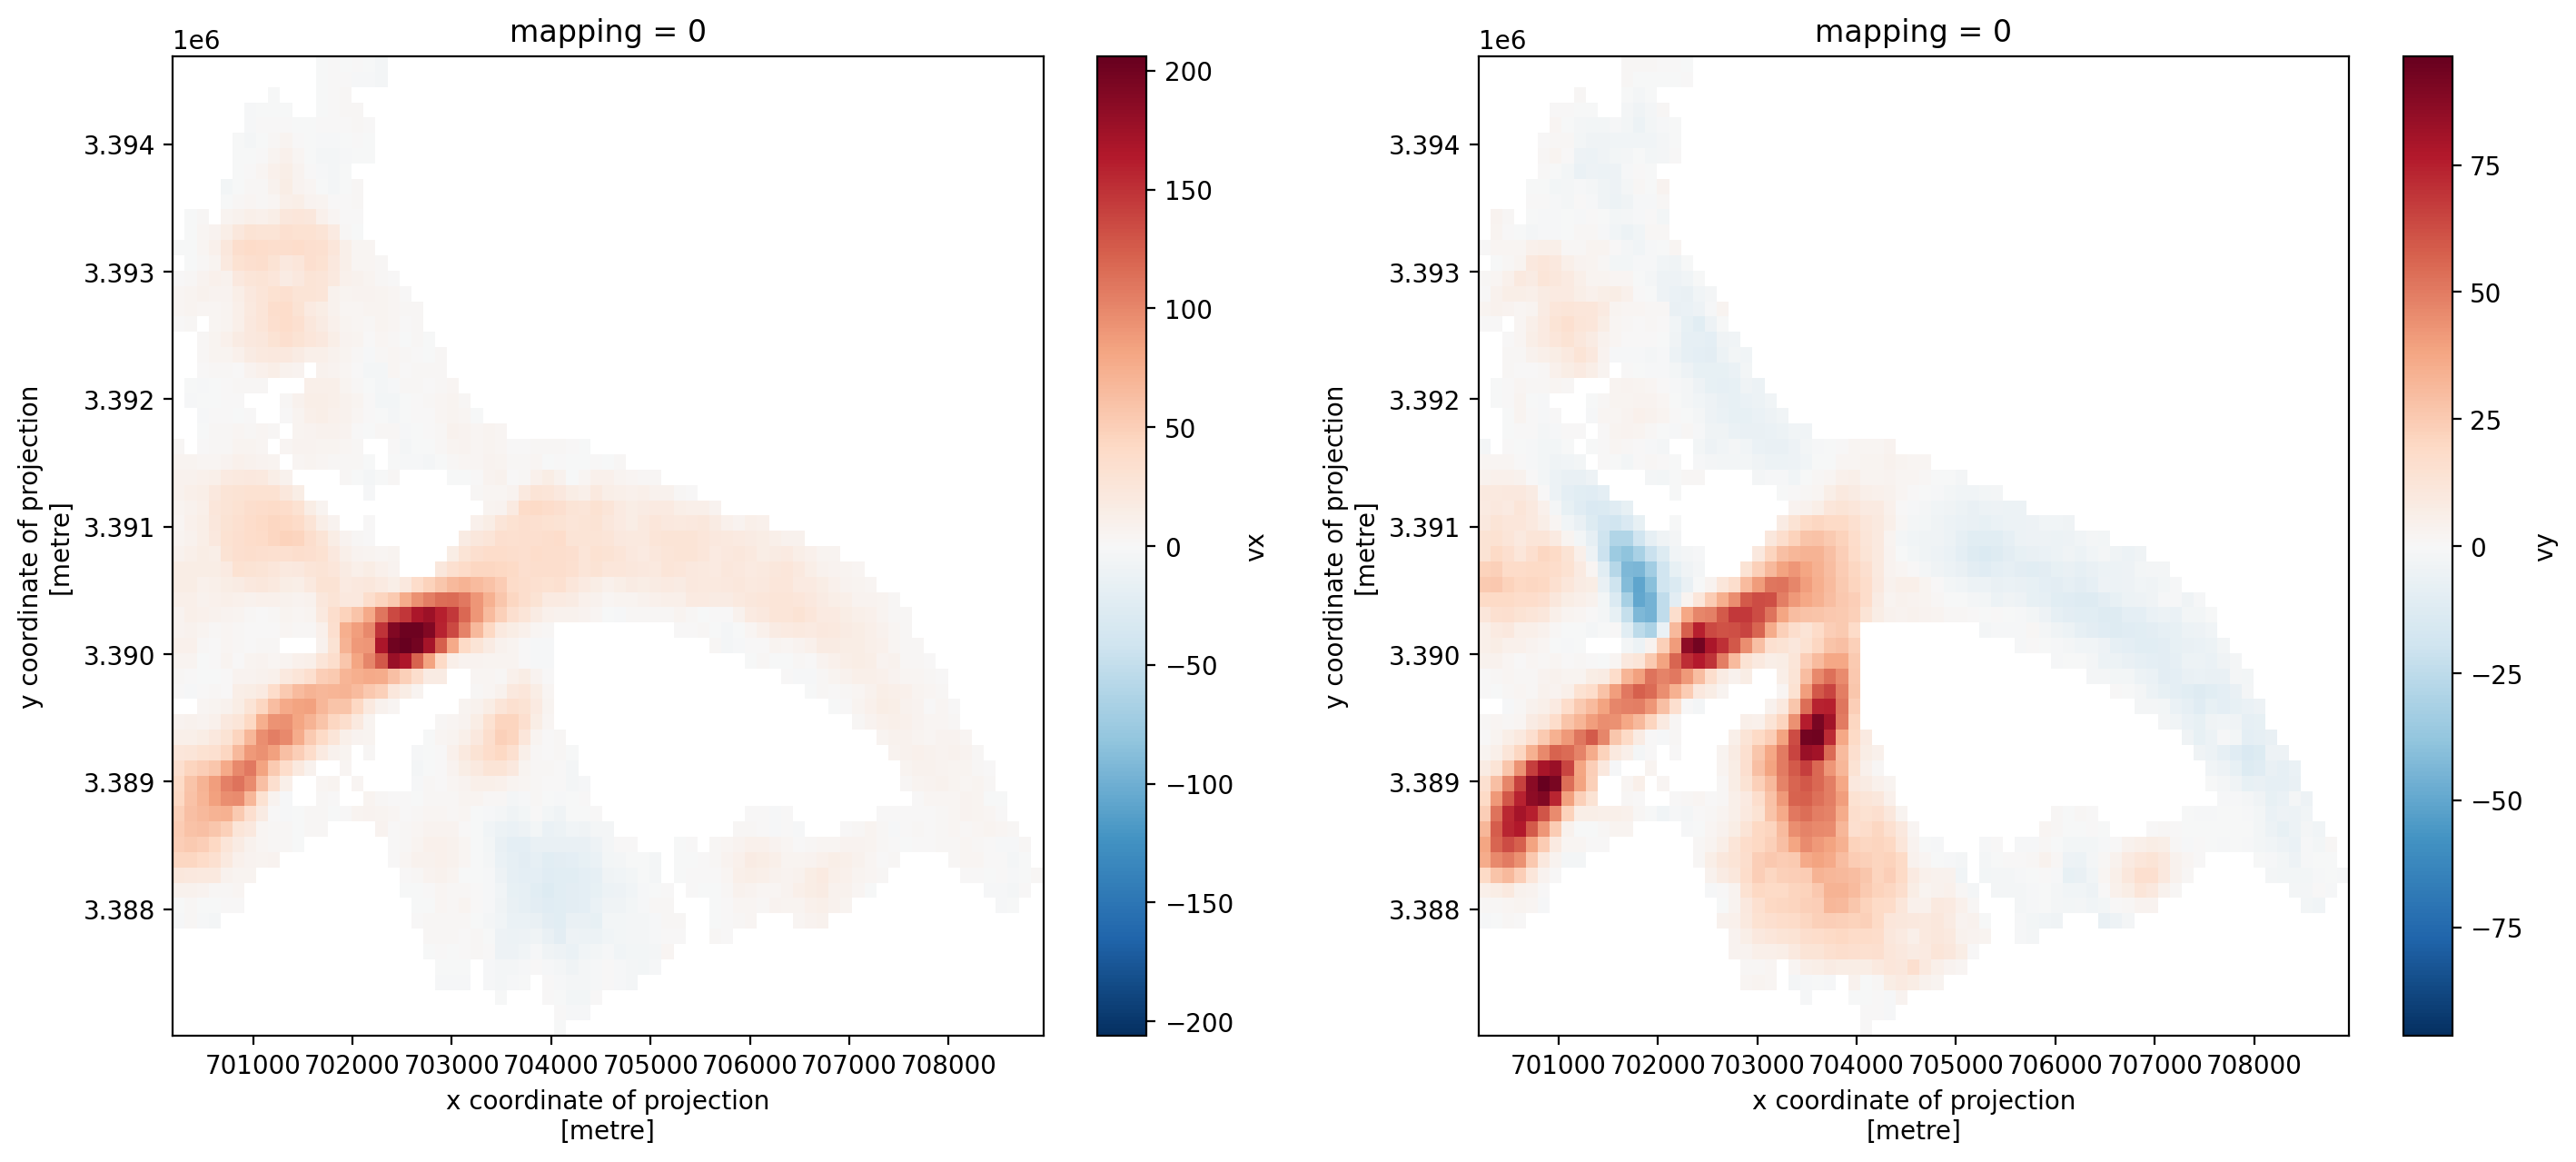

In [37]:
fig, axs = plt.subplots(ncols =2, figsize=(17,7))

sample_glacier_raster.vx.mean(dim='mid_date').plot(ax=axs[0]);
sample_glacier_raster.vy.mean(dim='mid_date').plot(ax=axs[1]);


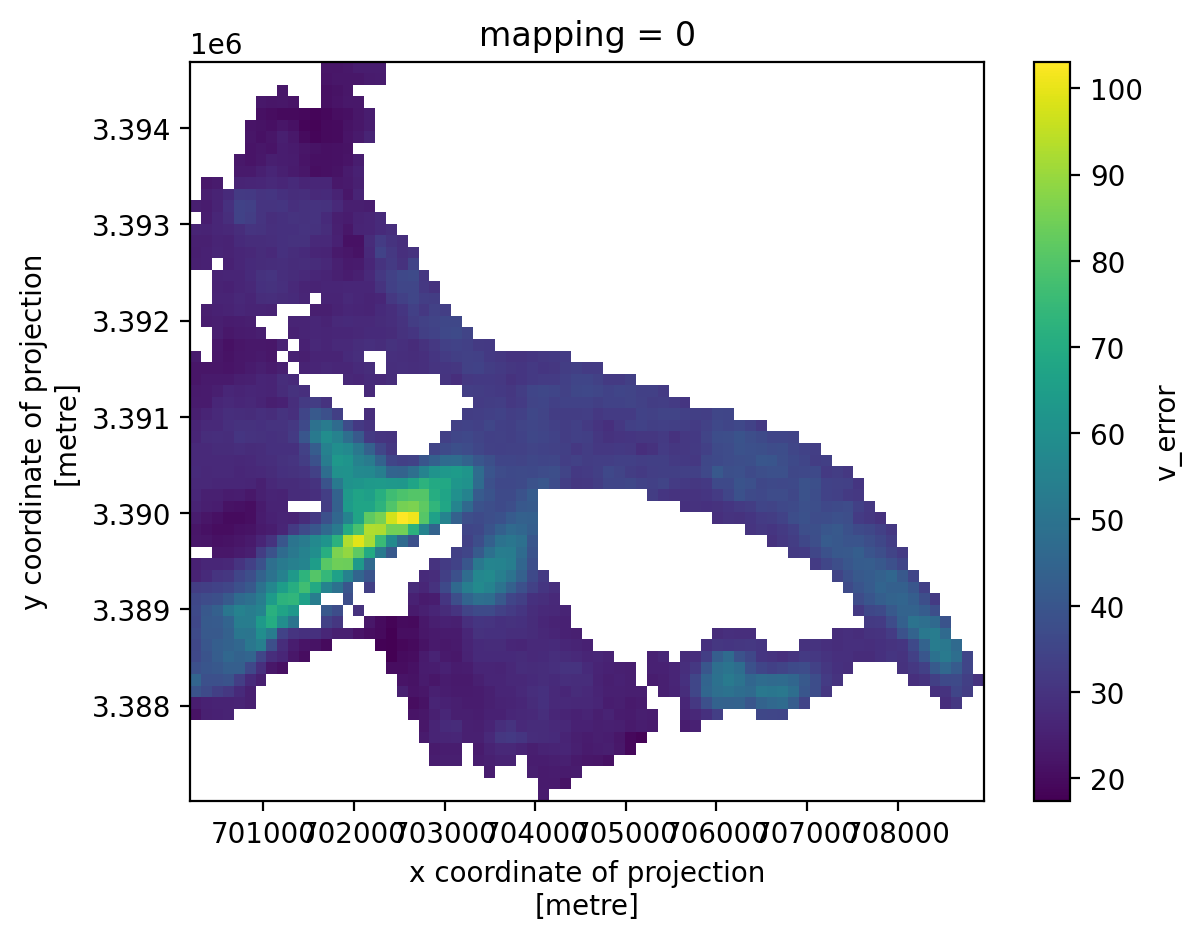

In [38]:
sample_glacier_raster.v_error.mean(dim=['mid_date']).plot();

## Exploring ITS_LIVE data

ITS_LIVE data cubes come with many (53!) variables that carry information about the estimated surface velocities and the satellite images that were used to generate the surface velocity estimates. We won't examine all of this information here but let's look at a litte bit.

To start with, let's look at the satellite imagery used to generate the velocity data.

We see that we have two `data_vars` that indicate which sensor that each image in the image pair at a certain time step comes from. We will "load" these values in to memory since we will use them later.

In [40]:
sample_glacier_raster.satellite_img2

<xarray.DataArray 'satellite_img2' (mid_date: 2000)>
array(['8', '8', '8', ..., '7', '7', '7'], dtype='<U2')
Coordinates:
  * mid_date  (mid_date) datetime64[ns] 2013-05-04T04:09:19.654660096 ... 201...
    mapping   int64 0
Attributes:
    description:    id of the satellite that acquired image 2
    standard_name:  image2_satellite

The `satellite_img1` and `satellite_img2` variables are 1-dimensional numpy arrays corresponding to the length of the `mid_date` dimension of the data cube. You can see that each element of the array is a string corresponding to a different satellite:
    `1A` = Sentinel 1A, `1B` = Sentinel 1B, `2A` = Sentinel 2A
    `2B` = Sentinel 2B, `8.` = Landsat8 and `9.` = Landsat9
    
Let's re-arrange these string arrays into a format that is easier to work with.

First, we'll make a set of all the different string values in the satellite image variables:

## Examining velocity data from each satellite in `ITS_LIVE` dataset

What if we only wanted to look at the velocity estimates from landat8?

In [43]:
l8_data = sample_glacier_raster.where(sample_glacier_raster['satellite_img1'] == '8', drop=True)
l8_data

<xarray.Dataset>
Dimensions:                     (mid_date: 662, y: 64, x: 73)
Coordinates:
  * mid_date                    (mid_date) datetime64[ns] 2017-12-25T04:11:40...
  * x                           (x) float64 7.003e+05 7.004e+05 ... 7.089e+05
  * y                           (y) float64 3.395e+06 3.395e+06 ... 3.387e+06
    mapping                     int64 0
Data variables: (12/59)
    M11                         (mid_date, y, x) float32 nan nan nan ... nan nan
    M11_dr_to_vr_factor         (mid_date) float32 nan nan nan ... nan nan nan
    M12                         (mid_date, y, x) float32 nan nan nan ... nan nan
    M12_dr_to_vr_factor         (mid_date) float32 nan nan nan ... nan nan nan
    acquisition_date_img1       (mid_date) datetime64[ns] 2017-12-21T04:10:40...
    acquisition_date_img2       (mid_date) datetime64[ns] 2017-12-29T04:12:40...
    ...                          ...
    vy_error_modeled            (mid_date) float32 1.163e+03 232.7 ... 166.2
    vy_error_slow               (mid_date) float32 112.5 37.6 54.1 ... 11.3 25.4
    vy_error_stationary         (mid_date) float32 112.5 37.6 54.2 ... 11.3 25.4
    vy_stable_shift             (mid_date) float32 -74.2 -25.7 ... -3.6 -10.8
    vy_stable_shift_slow        (mid_date) float32 -73.8 -25.7 ... -3.6 -10.7
    vy_stable_shift_stationary  (mid_date) float32 -74.2 -25.7 ... -3.6 -10.8
Attributes: (12/19)
    Conventions:                CF-1.8
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               25-Sep-2023 22:00:23
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v2/N30E090/ITS_L...
    skipped_granules:           s3://its-live-data/datacubes/v2/N30E090/ITS_L...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

`dataset.where()` at first seems appropriate to use for kind of operation but there's actually an easier way. Because we are selecting along a single dimension (`mid_date`), we can use xarray's `.sel()` method instead. This is more efficient and integrates with `dask` arrays more smoothly.

In [44]:
l8_condition = sample_glacier_raster.satellite_img1 == '8'
l8_subset = sample_glacier_raster.sel(mid_date=l8_condition)
l8_subset

<xarray.Dataset>
Dimensions:                     (mid_date: 662, y: 64, x: 73)
Coordinates:
  * mid_date                    (mid_date) datetime64[ns] 2017-12-25T04:11:40...
  * x                           (x) float64 7.003e+05 7.004e+05 ... 7.089e+05
  * y                           (y) float64 3.395e+06 3.395e+06 ... 3.387e+06
    mapping                     int64 0
Data variables: (12/59)
    M11                         (mid_date, y, x) float32 nan nan nan ... nan nan
    M11_dr_to_vr_factor         (mid_date) float32 nan nan nan ... nan nan nan
    M12                         (mid_date, y, x) float32 nan nan nan ... nan nan
    M12_dr_to_vr_factor         (mid_date) float32 nan nan nan ... nan nan nan
    acquisition_date_img1       (mid_date) datetime64[ns] 2017-12-21T04:10:40...
    acquisition_date_img2       (mid_date) datetime64[ns] 2017-12-29T04:12:40...
    ...                          ...
    vy_error_modeled            (mid_date) float32 1.163e+03 232.7 ... 166.2
    vy_error_slow               (mid_date) float32 112.5 37.6 54.1 ... 11.3 25.4
    vy_error_stationary         (mid_date) float32 112.5 37.6 54.2 ... 11.3 25.4
    vy_stable_shift             (mid_date) float32 -74.2 -25.7 ... -3.6 -10.8
    vy_stable_shift_slow        (mid_date) float32 -73.8 -25.7 ... -3.6 -10.7
    vy_stable_shift_stationary  (mid_date) float32 -74.2 -25.7 ... -3.6 -10.8
Attributes: (12/19)
    Conventions:                CF-1.8
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               25-Sep-2023 22:00:23
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v2/N30E090/ITS_L...
    skipped_granules:           s3://its-live-data/datacubes/v2/N30E090/ITS_L...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

We can see that we are looking at roughly a third of the original time steps. Let's take a look at the average speeds of the Landsat8-derived velocities:

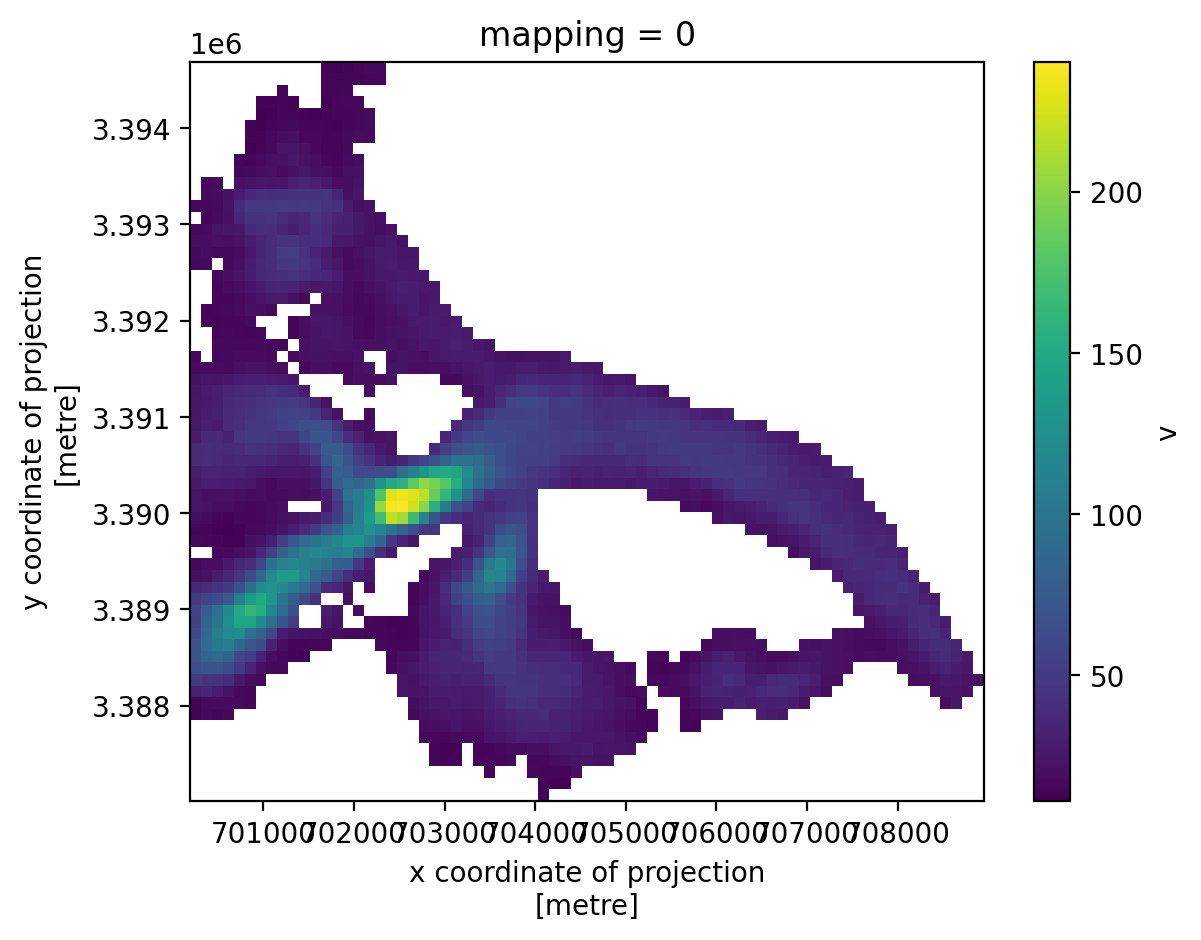

In [45]:
l8_subset.v.mean(dim='mid_date').plot();

What about Landsat7?

In [47]:
l7_condition = sample_glacier_raster.satellite_img1 == '7'

l7_subset = sample_glacier_raster.sel(mid_date=l7_condition)
l7_subset

<xarray.Dataset>
Dimensions:                     (mid_date: 803, y: 64, x: 73)
Coordinates:
  * mid_date                    (mid_date) datetime64[ns] 2017-11-11T04:11:45...
  * x                           (x) float64 7.003e+05 7.004e+05 ... 7.089e+05
  * y                           (y) float64 3.395e+06 3.395e+06 ... 3.387e+06
    mapping                     int64 0
Data variables: (12/59)
    M11                         (mid_date, y, x) float32 nan nan nan ... nan nan
    M11_dr_to_vr_factor         (mid_date) float32 nan nan nan ... nan nan nan
    M12                         (mid_date, y, x) float32 nan nan nan ... nan nan
    M12_dr_to_vr_factor         (mid_date) float32 nan nan nan ... nan nan nan
    acquisition_date_img1       (mid_date) datetime64[ns] 2017-05-03T04:12:55...
    acquisition_date_img2       (mid_date) datetime64[ns] 2018-05-22T04:10:35...
    ...                          ...
    vy_error_modeled            (mid_date) float32 24.2 24.2 21.5 ... 46.5 46.5
    vy_error_slow               (mid_date) float32 4.3 5.0 3.4 ... 23.3 6.6 9.7
    vy_error_stationary         (mid_date) float32 4.3 5.0 3.4 ... 23.3 6.6 9.7
    vy_stable_shift             (mid_date) float32 -0.3 3.2 -0.8 ... 10.8 3.4
    vy_stable_shift_slow        (mid_date) float32 -0.3 3.2 -0.8 ... 10.8 3.4
    vy_stable_shift_stationary  (mid_date) float32 -0.3 3.2 -0.8 ... 10.8 3.4
Attributes: (12/19)
    Conventions:                CF-1.8
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               25-Sep-2023 22:00:23
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v2/N30E090/ITS_L...
    skipped_granules:           s3://its-live-data/datacubes/v2/N30E090/ITS_L...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

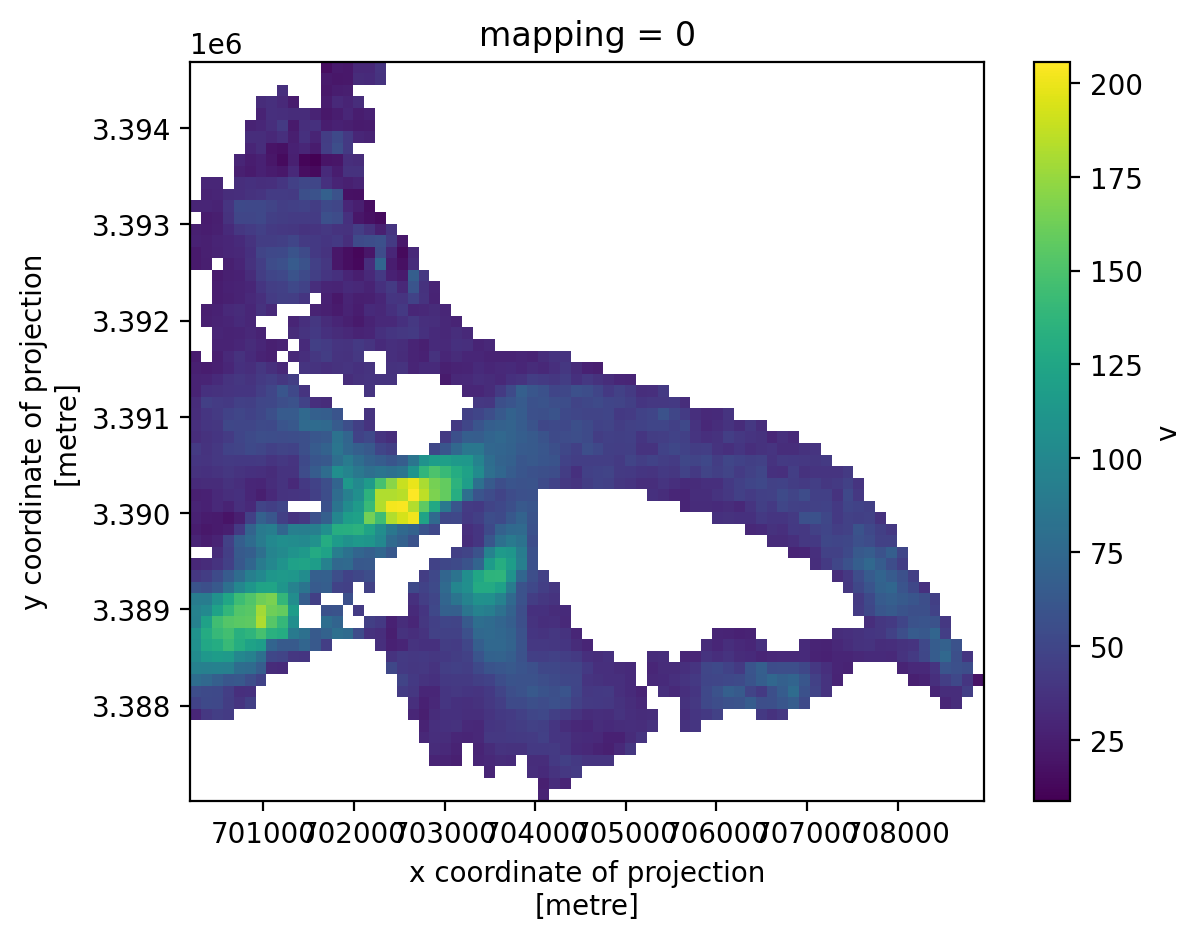

In [48]:
l7_subset.v.mean(dim='mid_date').plot();

Let's look at Sentinel 1 data. Note here we are selecting for 2 values instead of 1 using [DataArray.isin](https://xarray.pydata.org/en/stable/generated/xarray.DataArray.isin.html)

In [49]:
s1_condition = sample_glacier_raster.satellite_img1.isin(['1A','1B'])
s1_subset = sample_glacier_raster.sel(mid_date = s1_condition)
s1_subset

<xarray.Dataset>
Dimensions:                     (mid_date: 167, y: 64, x: 73)
Coordinates:
  * mid_date                    (mid_date) datetime64[ns] 2018-12-30T11:41:57...
  * x                           (x) float64 7.003e+05 7.004e+05 ... 7.089e+05
  * y                           (y) float64 3.395e+06 3.395e+06 ... 3.387e+06
    mapping                     int64 0
Data variables: (12/59)
    M11                         (mid_date, y, x) float32 nan nan nan ... nan nan
    M11_dr_to_vr_factor         (mid_date) float32 nan nan nan ... nan nan nan
    M12                         (mid_date, y, x) float32 nan nan nan ... nan nan
    M12_dr_to_vr_factor         (mid_date) float32 nan nan nan ... nan nan nan
    acquisition_date_img1       (mid_date) datetime64[ns] 2018-12-24T11:41:58...
    acquisition_date_img2       (mid_date) datetime64[ns] 2019-01-05T11:41:57...
    ...                          ...
    vy_error_modeled            (mid_date) float32 53.7 53.7 53.7 ... 53.7 53.7
    vy_error_slow               (mid_date) float32 55.8 48.2 77.2 ... 63.3 54.9
    vy_error_stationary         (mid_date) float32 55.8 48.2 77.2 ... 63.3 54.9
    vy_stable_shift             (mid_date) float32 0.0 -0.5 0.0 ... 0.5 -0.2 0.0
    vy_stable_shift_slow        (mid_date) float32 0.0 -0.5 0.0 ... 0.5 -0.2 0.0
    vy_stable_shift_stationary  (mid_date) float32 0.0 -0.5 0.0 ... 0.5 -0.2 0.0
Attributes: (12/19)
    Conventions:                CF-1.8
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               25-Sep-2023 22:00:23
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v2/N30E090/ITS_L...
    skipped_granules:           s3://its-live-data/datacubes/v2/N30E090/ITS_L...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

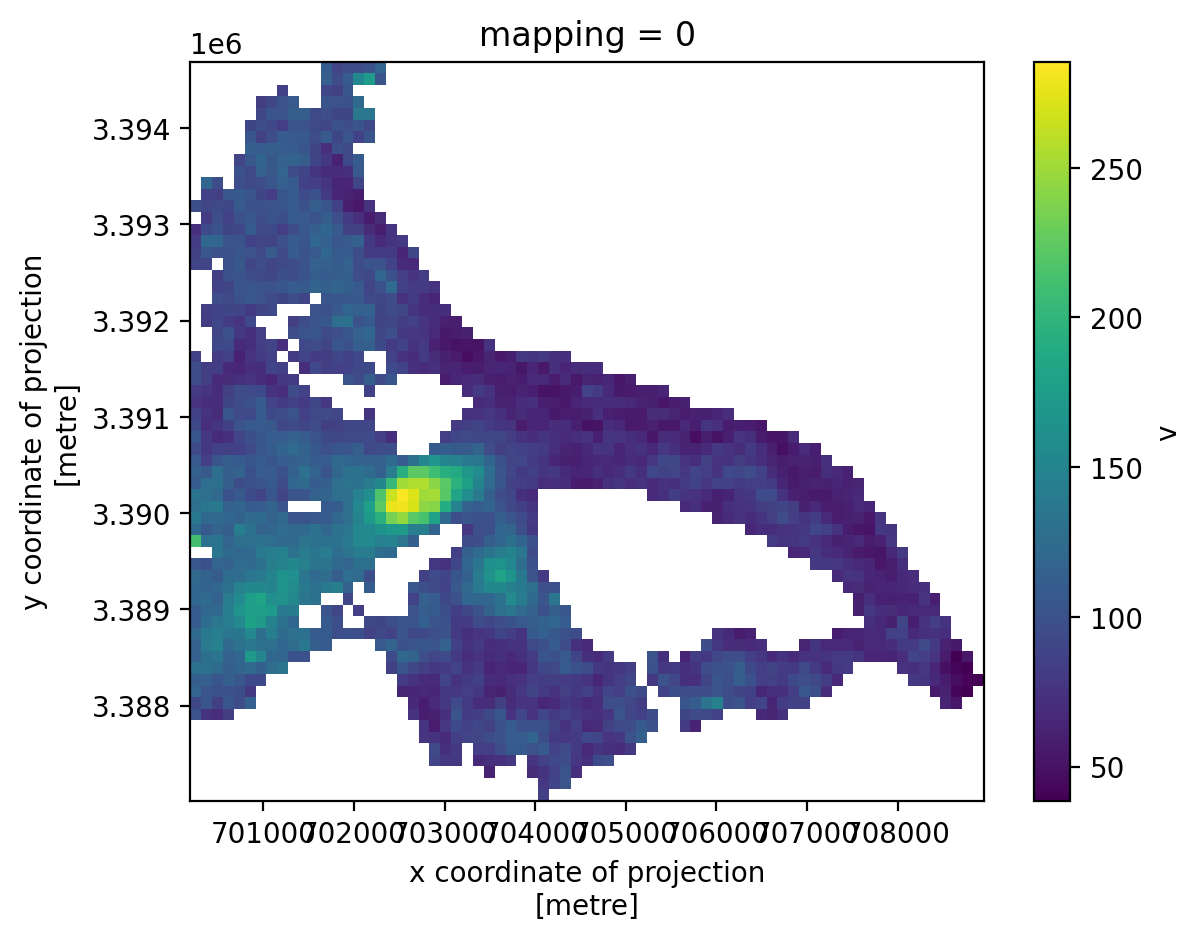

In [50]:
s1_subset.v.mean(dim='mid_date').plot();

In [51]:
s2_condition = sample_glacier_raster.satellite_img1.isin(['2A','2B'])
s2_subset = sample_glacier_raster.sel(mid_date=s2_condition)
s2_subset

<xarray.Dataset>
Dimensions:                     (mid_date: 2342, y: 64, x: 73)
Coordinates:
  * mid_date                    (mid_date) datetime64[ns] 2018-04-14T04:18:49...
  * x                           (x) float64 7.003e+05 7.004e+05 ... 7.089e+05
  * y                           (y) float64 3.395e+06 3.395e+06 ... 3.387e+06
    mapping                     int64 0
Data variables: (12/59)
    M11                         (mid_date, y, x) float32 nan nan nan ... nan nan
    M11_dr_to_vr_factor         (mid_date) float32 nan nan nan ... nan nan nan
    M12                         (mid_date, y, x) float32 nan nan nan ... nan nan
    M12_dr_to_vr_factor         (mid_date) float32 nan nan nan ... nan nan nan
    acquisition_date_img1       (mid_date) datetime64[ns] 2017-12-20T04:21:49...
    acquisition_date_img2       (mid_date) datetime64[ns] 2018-08-07T04:15:49...
    ...                          ...
    vy_error_modeled            (mid_date) float32 40.5 28.6 27.4 ... 60.0 30.0
    vy_error_slow               (mid_date) float32 8.0 1.7 1.2 ... 0.9 12.9 3.6
    vy_error_stationary         (mid_date) float32 8.0 1.7 1.2 ... 0.9 12.9 3.6
    vy_stable_shift             (mid_date) float32 8.9 -4.9 -0.7 ... 8.4 2.9
    vy_stable_shift_slow        (mid_date) float32 8.9 -4.9 -0.7 ... 8.4 2.9
    vy_stable_shift_stationary  (mid_date) float32 8.9 -4.9 -0.7 ... 8.4 2.9
Attributes: (12/19)
    Conventions:                CF-1.8
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               25-Sep-2023 22:00:23
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v2/N30E090/ITS_L...
    skipped_granules:           s3://its-live-data/datacubes/v2/N30E090/ITS_L...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

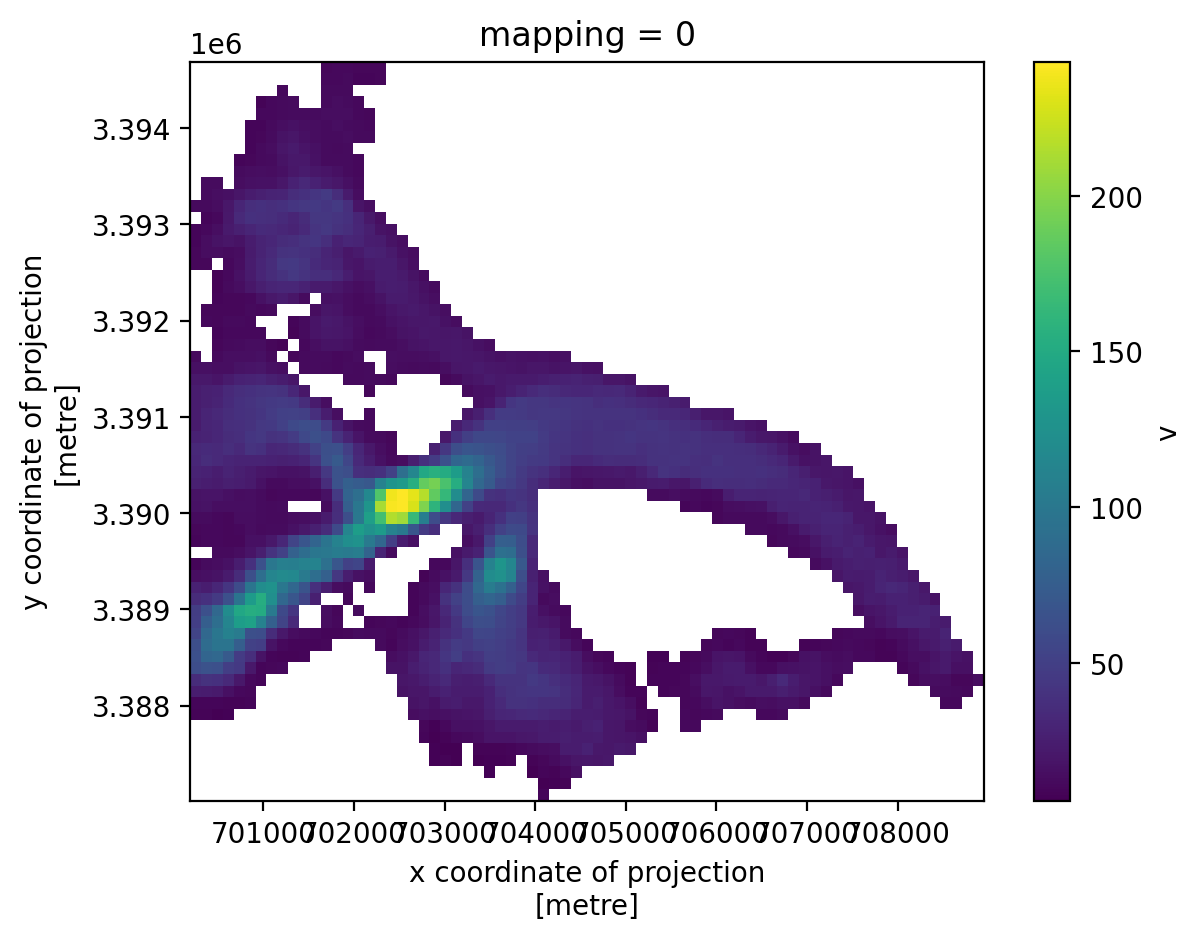

In [52]:
s2_subset.v.mean(dim='mid_date').plot();

ITS_LIVE is exciting because it combines velocity data from a number of satellites into one accessible and efficient dataset. From this brief look, you can see snapshot overviews of the different data within the dataset and begin to think about processing steps you might take to work with the data further.

## Checking coverage along a dimension
It would be nice to be able to scan/visualize and observe coverage of a variable along a dimension

First need to make a mask that will tell us all the possible 'valid' pixels. ie pixels over ice v. rock.

In [53]:
valid_pixels = sample_glacier_raster.v.count(dim=['x','y'])
valid_pix_max = sample_glacier_raster.v.notnull().any('mid_date').sum(['x','y'])

sample_glacier_raster['cov'] = valid_pixels/valid_pix_max



In [54]:
#how many time steps are duplicates?, there are 16872 unique vals in mid_dates
np.unique(sample_glacier_raster['mid_date'].data).shape

(3018,)

Start by grouping over `mid_date`. Would expect 16,872 (# unique time steps) with mostly groups of 1, groups of more than one on duplicate coords

In [55]:
test_gb = sample_glacier_raster.groupby(sample_glacier_raster.mid_date)
type(test_gb.groups)

dict

`test_gb.groups` is a [dict](https://xarray.pydata.org/en/stable/generated/xarray.core.groupby.DatasetGroupBy.groups.html), so let's explore that object. the keys correspond to `mid_date` coords, so the values should be the entries at that coordinate.

## Exploring data coverage over time series

Let's take a look at the data coverage over this glacier across the time series:

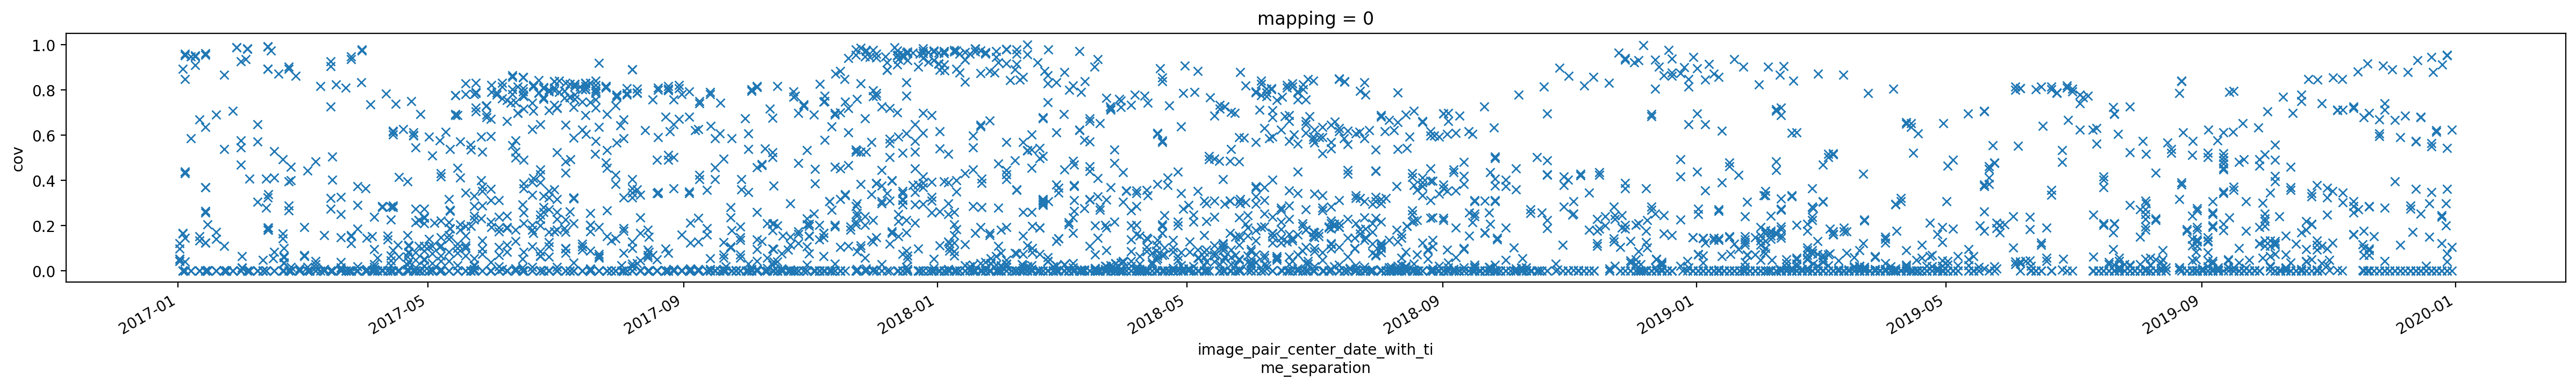

In [60]:
fig, ax = plt.subplots(figsize=(30,3))
sample_glacier_raster.cov.plot(ax=ax, linestyle='None',marker = 'x')

But what if we wanted to explore the relative coverage of the different sensors that make up the its_live dataset as a whole?
We can use `groupby` to group the data based on a single condition such as `satellite_img1` or `mid_date`.

In [61]:
sample_glacier_raster.cov.groupby(sample_glacier_raster.satellite_img1)

DataArrayGroupBy, grouped over 'satellite_img1'
5 groups with labels '1A', '2A', '2B', '7', '8'.

In [62]:
sample_glacier_raster.groupby('mid_date')

DatasetGroupBy, grouped over 'mid_date'
3018 groups with labels 2017-01-01T16:15:50.6605240....

However, if we want to examine the coverage of data from different sensor groups over time, we would essentially want to `groupby` two groups. To do this, we use [flox](https://flox.readthedocs.io/en/latest/)

In [63]:
import flox.xarray

This is the `xr.DataArray` on which we will perform the grouping operation using `flox`

In [66]:
sample_glacier_raster.cov

<xarray.DataArray 'cov' (mid_date: 3974)>
array([0.       , 0.       , 0.0036784, ..., 0.       , 0.       ,
       0.       ])
Coordinates:
  * mid_date  (mid_date) datetime64[ns] 2018-04-14T04:18:49.171219968 ... 201...
    mapping   int64 0

Using `flox`, we will define a coverage object that takes as inputs the data we want to reduce, the groups we want to use to group the data and the reduction we want to perform. 

In [67]:
coverage = flox.xarray.xarray_reduce(
    # array to reduce
    sample_glacier_raster.cov,
    # Grouping by two variables
    sample_glacier_raster.satellite_img1.compute(),
    sample_glacier_raster.mid_date,
    # reduction to apply in each group
    func="mean",
    # for when no elements exist in a group
    fill_value=0,
)

Now we can visualize the coverage over time for each sensor in the its_live dataset. Cool!

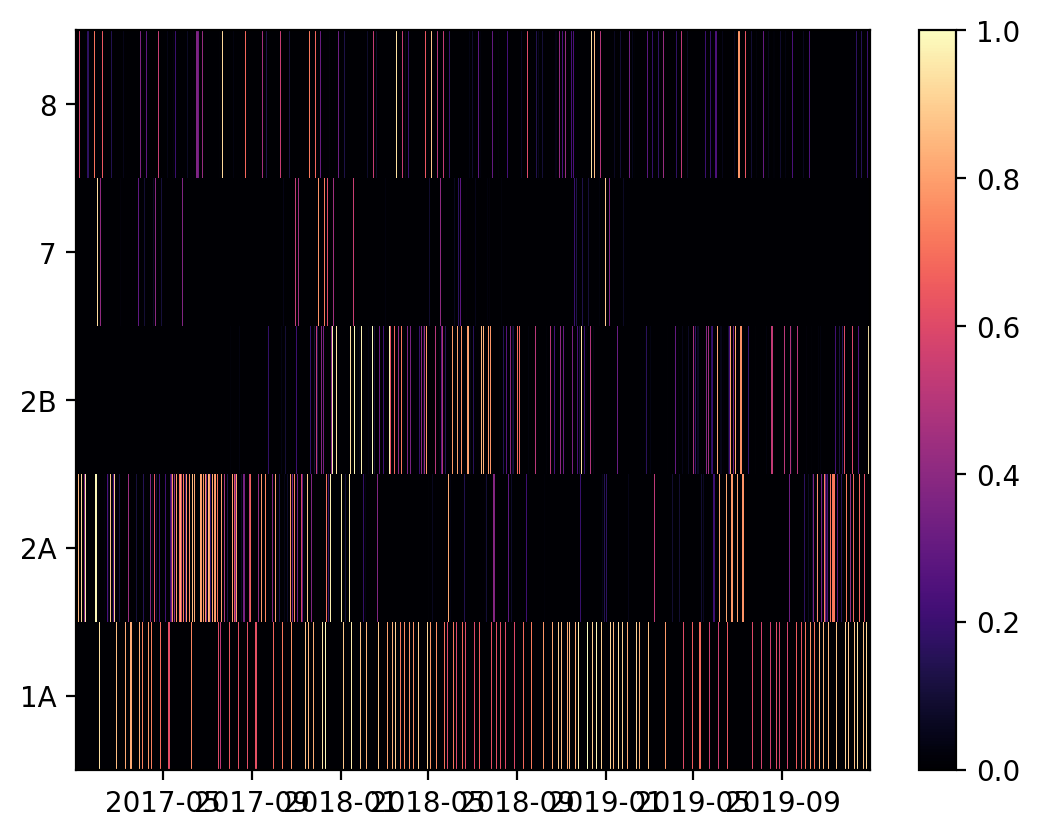

In [73]:
plt.pcolormesh(coverage.mid_date, coverage.satellite_img1, coverage, cmap='magma')
plt.colorbar();

### Conclusion 
This notebook displayed basic data inspection steps that you can take when working with a new dataset. The following notebooks will demonstrate further processing, analytical and visualization steps you can take. We will be working with the same object in the following notebook, so we can use cell magic to store the object and read it in in the next notebook, rather than making it all over again. You can read more about the magic command [here](https://ipython.readthedocs.io/en/stable/config/extensions/storemagic.html).

In [74]:
%store sample_glacier_raster

Stored 'sample_glacier_raster' (Dataset)
